# Modeling Walkthrough

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Modeling Steps

1. Build a model based on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) that predicts whether a given person survived or not
2. Evaluate the performance of the model
3. Make changes in an attempt to improve the model
4. Demonstrate whether an improvement was made

## The Data

This dataset has the following columns:

| Variable | Definition | Key |
| -------- | ---------- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial Data Understanding and Preparation

Open up the file, get everything into `X` features and `y` target variables, divided into train and test

In [73]:
df = pd.read_csv("titanic.csv")

In [74]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Age data is missing for about 1 in 9 rows in our dataset.  For now, let's just exclude it, plus the non-numeric columns, and `PassengerId` which doesn't seem like a real feature, but rather just an artifact of the dataset.

In [5]:
df = df.drop("PassengerId", axis=1)

In [6]:
# Pclass are numbers but it's not clear that the difference between 1st and 2nd is the
# same as the difference between 2nd and 3rd
numeric_columns = ["Survived", "SibSp", "Parch", "Fare"]

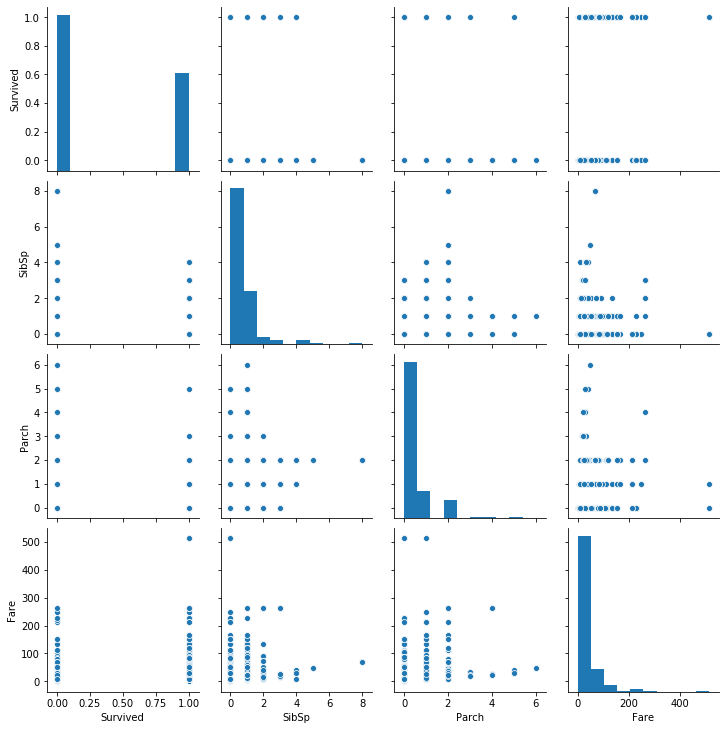

In [7]:
sns.pairplot(df[numeric_columns]);

In [8]:
numeric_df = df[numeric_columns]
X = numeric_df.drop("Survived", axis=1)
y = numeric_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)

## Modeling

Let's start with a completely "dummy" model, that will always choose the majority class.

In [9]:
dummy_model = DummyClassifier(strategy="most_frequent")

Fit the model on our data

In [10]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

We should expect all predictions to be the same

In [11]:
# just grabbing the first 50 to save space
dummy_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## Model Evaluation

In [12]:
cross_val_score(dummy_model, X_train, y_train, cv=3)

array([0.62331839, 0.62331839, 0.62612613])

So, the mean accuracy is a little over 62% if we always guess the majority class

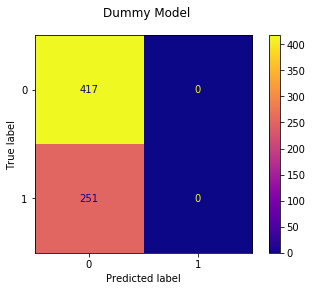

In [13]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

In [14]:
# just the numbers (this should work even with older scikit-learn)
confusion_matrix(y_train, dummy_model.predict(X_train))

array([[417,   0],
       [251,   0]])

A pretty lopsided confusion matrix!

## Modeling, Again

Let's use a logistic regression and compare its performance

In [15]:
simple_logreg_model = LogisticRegression(random_state=2020)

In [16]:
simple_logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2020)

Look at the predictions

In [17]:
simple_logreg_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

Mixture of 1s and 0s this time

## Model Evaluation, Again

In [18]:
cross_val_score(simple_logreg_model, X_train, y_train, cv=3)

array([0.68161435, 0.69955157, 0.67567568])

So the mean accuracy is closer to 70% if the model is actually taking in information from the features instead of always guessing the majority class

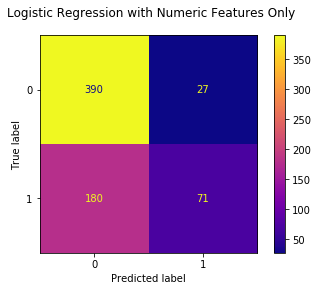

In [19]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Numeric Features Only")

plot_confusion_matrix(simple_logreg_model, X_train, y_train, ax=ax, cmap="plasma");

In [20]:
confusion_matrix(y_train, simple_logreg_model.predict(X_train))

array([[390,  27],
       [180,  71]])

So, in general we are not labeling many of the "not survived" passengers as "survived", but for "survived" passengers we're getting it right only about half of the time

## Data Preparation, Again

Maybe there is some useful information in the features we are not using yet.  Let's go wild and add all of them!

Note: you can and should add features incrementally in a "real" modeling context.  The engineering effort of encoding the variables can be non-trivial!  But here let's assume that it's not too much work to encode all of them.

Start with a new train-test split that contains all of the features

In [21]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)

In [22]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [23]:
X_train.isna().sum()

Pclass        0
Name          0
Sex           0
Age         123
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       516
Embarked      2
dtype: int64

### Handling Missing Values

Let's be extra cautious and make a separate column to indicate whether there originally was a missing value

In our training data there are only missing values for a couple of the columns, but we can't be sure about where the test set will be missing data

In [24]:
indicator = MissingIndicator(features="all")
indicator.fit(X_train)

MissingIndicator(features='all')

In [25]:
def add_missing_indicator_columns(X, indicator):
    """
    Helper function for transforming features
    
    For every feature in X, create another feature indicating whether that feature
    is missing.  This doubles the number of columns in X.
    """
    # create a 2D array of True and False values indicating whether a given feature
    # is missing for that row
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [26]:
X_train = add_missing_indicator_columns(X_train, indicator)

In [27]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,Ticket_missing,Fare_missing,Cabin_missing,Embarked_missing
620,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C,0,0,0,0,0,0,0,0,1,0
359,3,"Mockler, Miss. Helen Mary ""Ellie""",female,NaN,0,0,330980,7.8792,NaN,Q,0,0,0,1,0,0,0,0,1,0
512,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S,0,0,0,0,0,0,0,0,0,0
738,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S,0,0,0,1,0,0,0,0,1,0
420,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C,0,0,0,1,0,0,0,0,1,0


Now that we've specified which values were originally missing, let's fill in those missing values.  This takes two separate imputers because we want to use the mean for numeric data and the majority class for categorical data.

In [28]:
numeric_feature_names = ["Age", "SibSp", "Parch", "Fare"]
categorical_feature_names = ["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]

X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

In [29]:
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [30]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

In [31]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [32]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

Double-check to make sure that all of the missing values are gone:

In [33]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

Age         0
SibSp       0
Parch       0
Fare        0
Pclass      0
Name        0
Sex         0
Ticket      0
Cabin       0
Embarked    0
dtype: int64

Drop all of the old columns from X_train, then concat the new imputed ones

In [34]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [35]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass,Name,Sex,Ticket,Cabin,Embarked,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,Ticket_missing,Fare_missing,Cabin_missing,Embarked_missing
620,27.000000,1.0,0.0,14.4542,3,"Yasbeck, Mr. Antoni",male,2659,B96 B98,C,0,0,0,0,0,0,0,0,1,0
359,29.927982,0.0,0.0,7.8792,3,"Mockler, Miss. Helen Mary ""Ellie""",female,330980,B96 B98,Q,0,0,0,1,0,0,0,0,1,0
512,36.000000,0.0,0.0,26.2875,1,"McGough, Mr. James Robert",male,PC 17473,E25,S,0,0,0,0,0,0,0,0,0,0
738,29.927982,0.0,0.0,7.8958,3,"Ivanoff, Mr. Kanio",male,349201,B96 B98,S,0,0,0,1,0,0,0,0,1,0
420,29.927982,0.0,0.0,7.8958,3,"Gheorgheff, Mr. Stanio",male,349254,B96 B98,C,0,0,0,1,0,0,0,0,1,0


In [36]:
X_train.isna().sum()

Age                 0
SibSp               0
Parch               0
Fare                0
Pclass              0
Name                0
Sex                 0
Ticket              0
Cabin               0
Embarked            0
Pclass_missing      0
Name_missing        0
Sex_missing         0
Age_missing         0
SibSp_missing       0
Parch_missing       0
Ticket_missing      0
Fare_missing        0
Cabin_missing       0
Embarked_missing    0
dtype: int64

### One-Hot Encoding

Now that there are no missing values, convert all of the categorical features into numbers.

In [37]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [38]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [39]:
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [40]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,...,F G73,F2,F33,F38,F4,G6,T,C,Q,S
620,27.000000,1.0,0.0,14.4542,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
359,29.927982,0.0,0.0,7.8792,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
512,36.000000,0.0,0.0,26.2875,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
738,29.927982,0.0,0.0,7.8958,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420,29.927982,0.0,0.0,7.8958,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:
X_train.shape

(668, 1345)

This is...a ridiculous number of columns.  How did we end up with more columns than rows?

(Answer: each unique name and ticket number is now its own column)

## Modeling, Again

Let's run a logistic regression on our ridiculous number of columns

In [42]:
logreg_model = LogisticRegression(random_state=2020)
logreg_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=2020)

What happened there?  This solver had no problem before

Answer: it wasn't able to find the minimum with this number of steps in gradient descent

Let's try a couple of stopgap measures to get the model to run

In [43]:
logreg_model_more_iterations = LogisticRegression(random_state=2020, max_iter=1000)
logreg_model_more_iterations.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=2020)

In [44]:
logreg_model_more_regularization = LogisticRegression(random_state=2020, C=0.01)
logreg_model_more_regularization.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=2020)

In [45]:
logreg_model_higher_tolerance = LogisticRegression(random_state=2020, tol=100)
logreg_model_higher_tolerance.fit(X_train, y_train)

LogisticRegression(random_state=2020, tol=100)

## Model Evaluation, Again

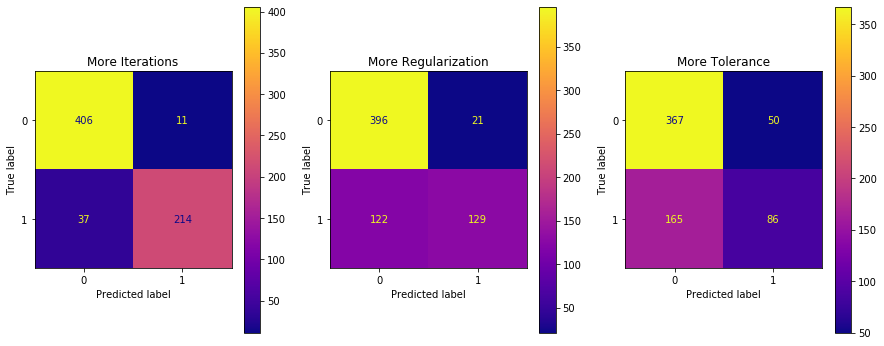

In [46]:
fix, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("More Regularization")
axes[2].set_title("More Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train, y_train, ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_more_regularization, X_train, y_train, ax=axes[1], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train, y_train, ax=axes[2], cmap="plasma");

In [47]:
print(cross_val_score(logreg_model_more_iterations, X_train, y_train, cv=3))
print(cross_val_score(logreg_model_more_regularization, X_train, y_train, cv=3))
print(cross_val_score(logreg_model_higher_tolerance, X_train, y_train, cv=3))

[0.78475336 0.84304933 0.81081081]
[0.74887892 0.75336323 0.74324324]
[0.69058296 0.67713004 0.66216216]


## Data Preparation, Again

Let's scale all of the features, so the model isn't overly penalizing age and fare

In [48]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [49]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [50]:
X_train = scale_values(X_train, scaler)

In [51]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,...,F G73,F2,F33,F38,F4,G6,T,C,Q,S
620,-2.197037e-01,0.445769,-0.488105,-0.367749,0.0,0.0,0.0,-0.475066,0.0,0.0,...,-0.0548,-0.0548,-0.03872,-0.03872,-0.03872,-0.067166,-0.03872,2.074027,-0.299537,-1.640307
359,-2.665810e-16,-0.473285,-0.488105,-0.501995,0.0,0.0,0.0,2.104969,0.0,0.0,...,-0.0548,-0.0548,-0.03872,-0.03872,-0.03872,-0.067166,-0.03872,-0.482154,3.338481,-1.640307
512,4.556193e-01,-0.473285,-0.488105,-0.126142,0.0,0.0,0.0,-0.475066,0.0,0.0,...,-0.0548,-0.0548,-0.03872,-0.03872,-0.03872,-0.067166,-0.03872,-0.482154,-0.299537,0.609642
738,-2.665810e-16,-0.473285,-0.488105,-0.501656,0.0,0.0,0.0,2.104969,0.0,0.0,...,-0.0548,-0.0548,-0.03872,-0.03872,-0.03872,-0.067166,-0.03872,-0.482154,-0.299537,0.609642
420,-2.665810e-16,-0.473285,-0.488105,-0.501656,0.0,0.0,0.0,2.104969,0.0,0.0,...,-0.0548,-0.0548,-0.03872,-0.03872,-0.03872,-0.067166,-0.03872,2.074027,-0.299537,-1.640307


## Modeling, Again

Now that the data is scaled, let's see if we can fit the model without tweaking any hyperparameters

In [52]:
logreg_model = LogisticRegression(random_state=2020)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2020)

## Model Evaluation, Again

Now that we are able to run a logistic regression with default hyperparameters, let's see how that performs

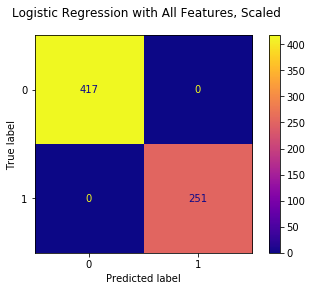

In [53]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

plot_confusion_matrix(logreg_model, X_train, y_train, ax=ax, cmap="plasma");

In [54]:
all_features_cross_val_score = cross_val_score(logreg_model, X_train, y_train, cv=3)
all_features_cross_val_score

array([0.76681614, 0.78026906, 0.76576577])

Perfect on the training data, high 70% range on the test data...this might be overfitting

In [55]:
sorted(list(zip(X_train.columns, logreg_model.coef_[0])), key=lambda x: abs(x[1]), reverse=True)[:50]

[('male', -0.7643948972144895),
 ('female', 0.7643948972144894),
 (3, -0.3842269319344764),
 ('Cabin_missing', -0.3106443704109742),
 ('B96 B98', -0.28210405736415317),
 (1, 0.28200801726585234),
 ('Allison, Master. Hudson Trevor', 0.27079097245621253),
 ('1601', 0.24220424332847068),
 ('Asplund, Master. Edvin Rojj Felix', 0.2336390887279502),
 ('Goldsmith, Master. Frank John William "Frankie"', 0.2329641007817835),
 ('Davies, Master. John Morgan Jr', 0.2305843714254912),
 ('Fare', 0.22844987001239395),
 ('Age', -0.22581470391094954),
 ('Foo, Mr. Choong', 0.2233177722368761),
 ('Chip, Mr. Chang', 0.21403931451919844),
 ('Bing, Mr. Lee', 0.2140393145191976),
 ('Allison, Miss. Helen Loraine', -0.21342729393489557),
 ('Mallet, Master. Andre', 0.20855636091090302),
 ('29106', 0.20566751837721436),
 ('347082', -0.20327783745510963),
 ('Allison, Mrs. Hudson J C (Bessie Waldo Daniels)', -0.2007465158820807),
 ('Navratil, Master. Edmond Roger', 0.19647537938215234),
 ('113760', 0.1914098471150

## Hyperparameter Tuning

Let's try out some different regularization penalties to see if we can improve the test data score a bit

In [56]:
logreg_model = LogisticRegression(random_state=2020, C=0.1)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.76233184 0.76681614 0.75675676]


Seems like it doesn't make a difference

Try a little less regularization:

In [57]:
logreg_model = LogisticRegression(random_state=2020, C=0.5)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.76233184 0.77578475 0.76576577]


Same or worse

Try a little more regularization:

In [58]:
logreg_model = LogisticRegression(random_state=2020, C=0.05)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.75784753 0.77130045 0.74774775]


Also worse.  It looks like the default C value is pretty optimal for this solver.

Let's try some other solvers

In [59]:
logreg_model = LogisticRegression(random_state=2020, solver="liblinear")
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.78026906 0.78026906 0.77027027]


A little slower, but no major difference in the scores.  Let's try adding some more regularization

In [60]:
logreg_model = LogisticRegression(random_state=2020, solver="liblinear", C=0.01)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.78026906 0.78475336 0.76126126]


Getting better.  Try a different type of penalty:

In [61]:
logreg_model = LogisticRegression(random_state=2020, solver="liblinear", penalty="l1")
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.77130045 0.82511211 0.7972973 ]


Slightly better average here.  Try adding some more regularization with L1 penalty:

In [62]:
logreg_model = LogisticRegression(random_state=2020, solver="liblinear", penalty="l1", C=0.01)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.76681614 0.78026906 0.76576577]
New: [0.76681614 0.8206278  0.7972973 ]


Still, the default regularization strength seems pretty good.  Double-check the confusion matrix:

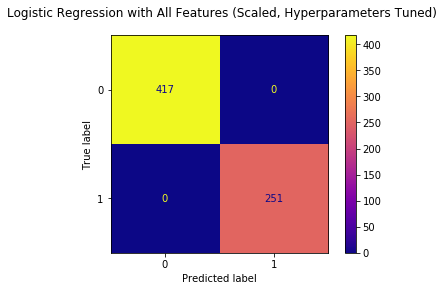

In [63]:
logreg_model = LogisticRegression(random_state=2020, solver="liblinear", penalty="l1")
logreg_model.fit(X_train, y_train)

fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features (Scaled, Hyperparameters Tuned)")

plot_confusion_matrix(logreg_model, X_train, y_train, ax=ax, cmap="plasma");

Probably still overfitting, but let's call this our final model!

## Final Model Evaluation

Now that we have a final model, run X_test through all of the preprocessing steps so we can evaluate the model's performance

In [64]:
X_test_no_transformations = X_test.copy()

In [65]:
# add missing indicators
X_test = add_missing_indicator_columns(X_test, indicator)

In [66]:
# separate out values for imputation
X_test_numeric = X_test[numeric_feature_names]
X_test_categorical = X_test[categorical_feature_names]

In [67]:
# impute missing values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test = X_test.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_test = pd.concat([X_test_imputed, X_test], axis=1)

In [68]:
# one-hot encode categorical data
for categorical_feature in categorical_feature_names:
    X_test = encode_and_concat_feature(X_test, categorical_feature, encoders[categorical_feature])

In [69]:
# scale values
X_test = scale_values(X_test, scaler)

Create a model with the relevant hyperparameters, fit, and score

In [70]:
final_model = LogisticRegression(random_state=2020, solver="liblinear", penalty="l1")
final_model.fit(X_train, y_train)

final_model.score(X_test, y_test)

0.7847533632286996

In [71]:
final_scores_dict = {
    "Mean Accuracy": [
        dummy_model.score(X_test, y_test), 
        simple_logreg_model.score(X_test_no_transformations[["SibSp", "Parch", "Fare"]], y_test),
        final_model.score(X_test, y_test)
    ]
}
final_scores_df = pd.DataFrame(final_scores_dict, index=["Dummy Model", "Simple Linear Regression Model", "Final Model"])
final_scores_df

,Mean Accuracy
Dummy Model,0.591928
Simple Linear Regression Model,0.623318
Final Model,0.784753


Final comparison of confusion matrices

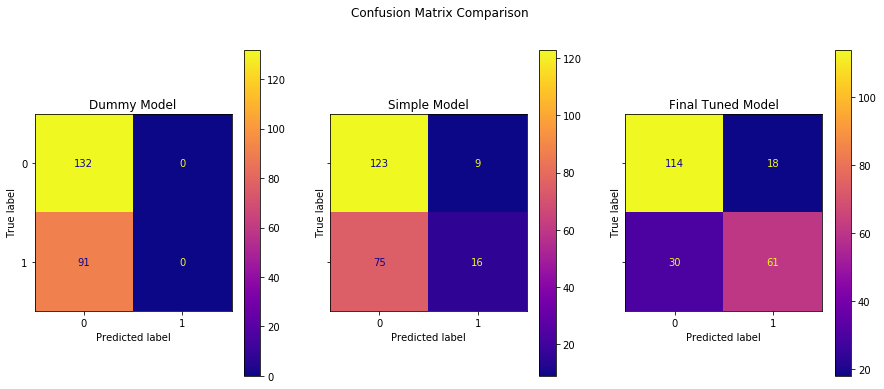

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), sharey=True)

fig.suptitle("Confusion Matrix Comparison")

axes[0].set_title("Dummy Model")
axes[1].set_title("Simple Model")
axes[2].set_title("Final Tuned Model")

plot_confusion_matrix(dummy_model, X_test, y_test, ax=axes[0], cmap="plasma")
plot_confusion_matrix(simple_logreg_model, X_test_no_transformations[["SibSp", "Parch", "Fare"]], y_test, ax=axes[1], cmap="plasma")
plot_confusion_matrix(final_model, X_test, y_test, ax=axes[2], cmap="plasma");